# **PhawAI: Predicción de enfermedades coronarias**

## **Resumen**

El desafío consiste en desarrollar un modelo de machine learning para predecir la presencia de enfermedades coronarias en individuos usando un conjunto de datos real proporcionado por el Behavioral Risk Factor Surveillance System (BRFSS) de 2022 [1]. Este dataset incluye información demográfica, comportamientos de salud, y condiciones previas diagnosticadas, presentando además un desbalance de clases significativo entre los casos positivos y negativos de enfermedad coronaria. Los participantes deben explorar técnicas avanzadas de balanceo de clases, limpieza de datos y selección de características para optimizar la precisión en la detección de enfermedades del corazón.

## **Dataset**

El dataset BRFSS 2022 [1] contiene aproximadamente 438,000 registros provenientes de encuestas telefónicas realizadas en los Estados Unidos, incluyendo sus territorios. De las 328 variables disponibles en el dataset completo, se han seleccionado las siguientes 27 variables consideradas más relevantes para la predicción de enfermedades coronarias. La variable objetivo es "CHD_OR_MI", que indica con "1" si el individuo ha sido diagnosticado con enfermedad coronaria o infarto de miocardio y con "0" si el individuo no presenta ninguna enfermedad coronaria.

- CHD_OR_MI: Diagnóstico de enfermedad coronaria o infarto (variable objetivo)
- SEX: Género del encuestado
- AGE: Edad del encuestado
- HEALTH: Autoevaluación de la salud general
- PHYSICAL_HEALTH: Días de mala salud física en el último mes
- MENTAL_HEALTH: Días de mala salud mental en el último mes
- PHYSICAL_ACTIVITIES: Realización de actividad física regular
- BLOOD_PRESSURE: Diagnóstico de presión arterial alta
- HIGH_CHOLESTEROL: Diagnóstico de colesterol alto
- SKIN_CANCER: Diagnóstico previo de cáncer de piel
- CANCER: Diagnóstico de cáncer, excluyendo cáncer de piel
- BRONCHITIS: Diagnóstico previo de bronquitis
- DEPRESSIVE_DISORDER: Diagnóstico previo de trastorno depresivo
- KIDNEY_DISEASE: Diagnóstico previo de enfermedad renal
- DIABETES: Diagnóstico previo de diabetes
- ARTHRITIS: Diagnóstico previo de artritis
- BMI: Índice de Masa Corporal
- DIFFICULTY_WALKING: Dificultad para caminar
- SMOKE: Ha fumado al menos 100 cigarrillos en la vida
- TABACCO_PRODUCTS: Uso de otros productos de tabaco
- E_CIGARETTES: Uso de cigarrillos electrónicos
- HEAVY_DRINKERS: Consumo elevado de alcohol
- HIV: Diagnóstico de VIH
- FRUITS: Consumo regular de frutas
- VEGETABLES: Consumo regular de vegetales
- FRIED_POTATOES: Frecuencia de consumo de papas fritas
- ETHNICITY: Etnia del encuestado
- ID: Código del paciente

## **Exploración inicial del dataset**

### **1. Carga de Datos**

In [50]:
# Básicas
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y manejo de valores faltantes
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Balanceo de clases
from imblearn.over_sampling import SMOTE

# División de datos
from sklearn.model_selection import train_test_split, GridSearchCV

# Modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# Evaluación de modelos
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix

# Manejo de advertencias
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [51]:
train_path = 'train.csv'  # Ruta al dataset de entrenamiento
test_public_path = 'test_public.csv'  # Ruta al dataset de prueba público
test_private_path = 'test_private.csv'  # Ruta al dataset de prueba privado

# Leer los archivos CSV en DataFrames
train_df = pd.read_csv(train_path)
test_public_df = pd.read_csv(test_public_path)
test_private_df = pd.read_csv(test_private_path)

In [52]:
# Dimensiones de los datos
print("========== Dimensiones de los Datos ==========")
print(f"Datos de entrenamiento: {train_df.shape}")
print(f"Datos de prueba pública: {test_public_df.shape}")
print(f"Datos de prueba privada: {test_private_df.shape}\n")

# Tipos de datos
data_types = pd.DataFrame({
    "Entrenamiento": train_df.dtypes,
    "Prueba Pública": test_public_df.dtypes,
    "Prueba Privada": test_private_df.dtypes
})

# Mostrar tipos de datos
print("========== Tipos de Datos ==========")
print(data_types)

========== Dimensiones de los Datos ==========
Datos de entrenamiento: (347246, 28)
Datos de prueba pública: (43406, 28)
Datos de prueba privada: (43406, 27)

========== Tipos de Datos ==========
                    Entrenamiento Prueba Pública Prueba Privada
AGE                         int64          int64          int64
ARTHRITIS                 float64        float64        float64
BLOOD_PRESSURE            float64        float64        float64
BMI                       float64        float64        float64
BRONCHITIS                float64        float64        float64
CANCER                    float64        float64        float64
CHD_OR_MI                 float64        float64            NaN
DEPRESSIVE_DISORDER       float64        float64        float64
DIABETES                  float64        float64        float64
DIFFICULTY_WALKING        float64        float64        float64
ETHNICITY                   int64          int64          int64
E_CIGARETTES              float64   

In [53]:
# Eliminar la columna ID del conjunto de entrenamiento
if 'ID' in train_df.columns:
    train_df = train_df.drop(columns=['ID'])

# Confirmar que la columna se ha eliminado
print("Columnas después de eliminar 'ID':")
print(train_df.columns)

Columnas después de eliminar 'ID':
Index(['CHD_OR_MI', 'SEX', 'AGE', 'HEALTH', 'PHYSICAL_HEALTH', 'MENTAL_HEALTH',
       'PHYSICAL_ACTIVITIES', 'BLOOD_PRESSURE', 'HIGH_CHOLESTEROL',
       'SKIN_CANCER', 'CANCER', 'BRONCHITIS', 'DEPRESSIVE_DISORDER',
       'KIDNEY_DISEASE', 'DIABETES', 'ARTHRITIS', 'BMI', 'DIFFICULTY_WALKING',
       'SMOKE', 'TABACCO_PRODUCTS', 'E_CIGARETTES', 'HEAVY_DRINKERS', 'HIV',
       'FRUITS', 'VEGETABLES', 'FRIED_POTATOES', 'ETHNICITY'],
      dtype='object')


### **2. Valores faltantes**

In [54]:
# Calcular valores faltantes
missing_values = train_df.isnull().sum()

# Calcular correlación con la variable objetivo
correlations = train_df.corr(numeric_only=True)['CHD_OR_MI']

# Crear un DataFrame combinado
missing_corr = pd.DataFrame({
    "Valores Faltantes": missing_values,
    "Correlación con CHD_OR_MI": correlations
})

# Filtrar para no mostrar la variable objetivo
missing_corr_filtered = missing_corr.drop(index=['CHD_OR_MI'])

# Ordenar por valores faltantes de mayor a menor
missing_corr_sorted = missing_corr_filtered.sort_values(by="Valores Faltantes", ascending=False)

# Mostrar el DataFrame ordenado
print("========== Valores Faltantes y Correlación ==========")
print(missing_corr_sorted)

========== Valores Faltantes y Correlación ==========
                     Valores Faltantes  Correlación con CHD_OR_MI
HIGH_CHOLESTEROL                 50191                   0.170687
VEGETABLES                       47387                  -0.017577
HIV                              40794                  -0.020797
FRUITS                           40254                  -0.003845
BMI                              36960                  -0.041501
FRIED_POTATOES                   35302                  -0.022453
HEAVY_DRINKERS                   27583                   0.027429
SMOKE                            19263                   0.109667
E_CIGARETTES                     18884                  -0.014002
TABACCO_PRODUCTS                 18033                   0.003289
DIFFICULTY_WALKING               15604                   0.201933
PHYSICAL_HEALTH                   7306                  -0.152926
MENTAL_HEALTH                     6034                  -0.007364
ARTHRITIS             

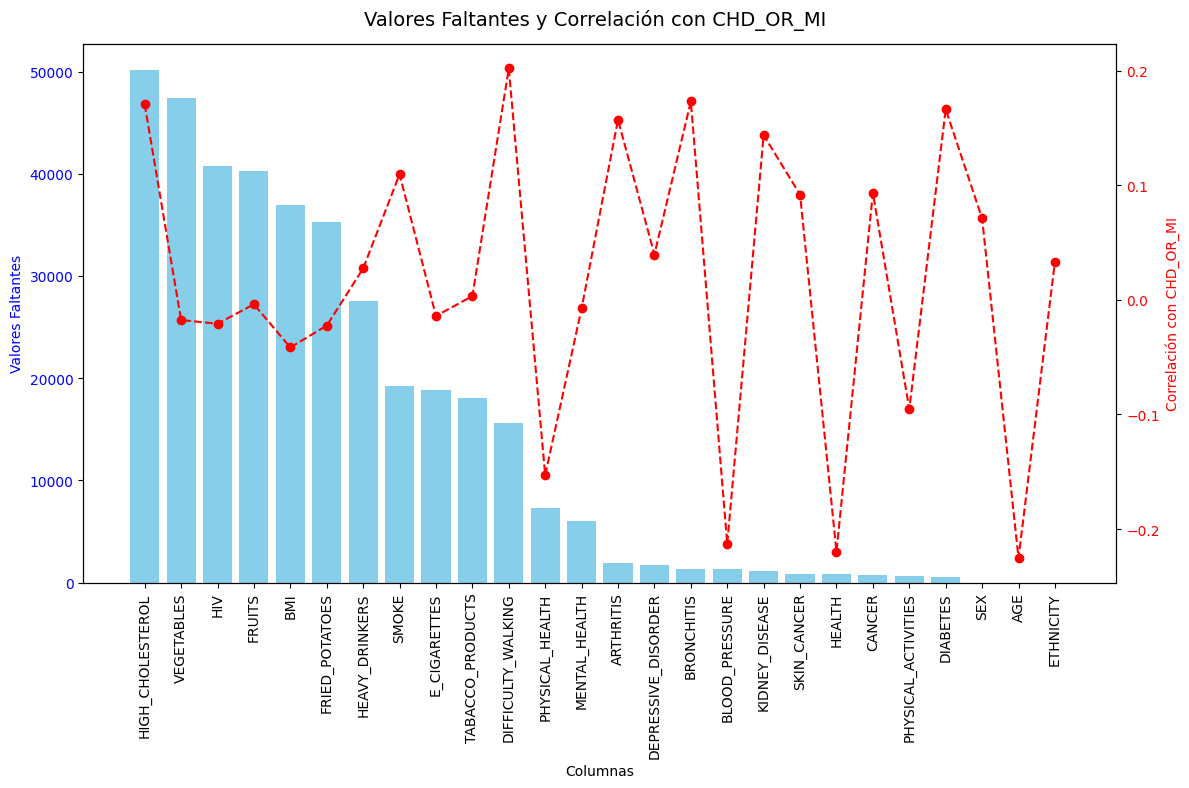

In [55]:
# Gráfico de valores faltantes y correlación
def plot_missing_values_and_correlation(missing_corr_sorted):
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Gráfico de barras para los valores faltantes
    ax1.bar(
        missing_corr_sorted.index,
        missing_corr_sorted["Valores Faltantes"],
        color="skyblue",
        label="Valores Faltantes"
    )
    ax1.set_xlabel("Columnas")
    ax1.set_ylabel("Valores Faltantes", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.set_xticklabels(missing_corr_sorted.index, rotation=90)

    # Línea para la correlación con CHD_OR_MI
    ax2 = ax1.twinx()
    ax2.plot(
        missing_corr_sorted.index,
        missing_corr_sorted["Correlación con CHD_OR_MI"],
        color="red",
        marker="o",
        linestyle="--",
        label="Correlación con CHD_OR_MI"
    )
    ax2.set_ylabel("Correlación con CHD_OR_MI", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    # Agregar leyendas y título
    fig.suptitle("Valores Faltantes y Correlación con CHD_OR_MI", fontsize=14)
    fig.tight_layout()
    plt.show()

# Llamar a la función para graficar
plot_missing_values_and_correlation(missing_corr_sorted)

## **Limpieza y Preprocesamiento de Datos**

### **1. Limpieza de Datos con Baja Correlación**

In [56]:
# Calcular correlaciones con la variable objetivo en el conjunto de entrenamiento
correlations = train_df.corr(numeric_only=True)['CHD_OR_MI']

# Identificar columnas con correlación entre -0.04 y 0.04
low_corr_columns = correlations[(correlations > -0.04) & (correlations < 0.04)].index

# Eliminar las columnas de baja correlación en todos los datasets
train_df_filtered = train_df.drop(columns=low_corr_columns)
test_public_df_filtered = test_public_df.drop(columns=low_corr_columns, errors='ignore')
test_private_df_filtered = test_private_df.drop(columns=low_corr_columns, errors='ignore')

# Mostrar resultados
print("========== Columnas Eliminadas ==========")
print(f"Por correlación baja (-0.04 a 0.04): {list(low_corr_columns)}")

print("\n========== Columnas Restantes en el Conjunto de Entrenamiento ==========")
print(train_df_filtered.columns)

print("\n========== Columnas Restantes en el Conjunto de Prueba Pública ==========")
print(test_public_df_filtered.columns)

print("\n========== Columnas Restantes en el Conjunto de Prueba Privada ==========")
print(test_private_df_filtered.columns)

========== Columnas Eliminadas ==========
Por correlación baja (-0.04 a 0.04): ['MENTAL_HEALTH', 'DEPRESSIVE_DISORDER', 'TABACCO_PRODUCTS', 'E_CIGARETTES', 'HEAVY_DRINKERS', 'HIV', 'FRUITS', 'VEGETABLES', 'FRIED_POTATOES', 'ETHNICITY']

========== Columnas Restantes en el Conjunto de Entrenamiento ==========
Index(['CHD_OR_MI', 'SEX', 'AGE', 'HEALTH', 'PHYSICAL_HEALTH',
       'PHYSICAL_ACTIVITIES', 'BLOOD_PRESSURE', 'HIGH_CHOLESTEROL',
       'SKIN_CANCER', 'CANCER', 'BRONCHITIS', 'KIDNEY_DISEASE', 'DIABETES',
       'ARTHRITIS', 'BMI', 'DIFFICULTY_WALKING', 'SMOKE'],
      dtype='object')

========== Columnas Restantes en el Conjunto de Prueba Pública ==========
Index(['CHD_OR_MI', 'SEX', 'AGE', 'HEALTH', 'PHYSICAL_HEALTH',
       'PHYSICAL_ACTIVITIES', 'BLOOD_PRESSURE', 'HIGH_CHOLESTEROL',
       'SKIN_CANCER', 'CANCER', 'BRONCHITIS', 'KIDNEY_DISEASE', 'DIABETES',
       'ARTHRITIS', 'BMI', 'DIFFICULTY_WALKING', 'SMOKE', 'ID'],
      dtype='object')

========== Columnas Restantes en

### **2. Tratamiento de Outliers y Transformaciones de Variables**

========== Tratamiento de Outliers ==========


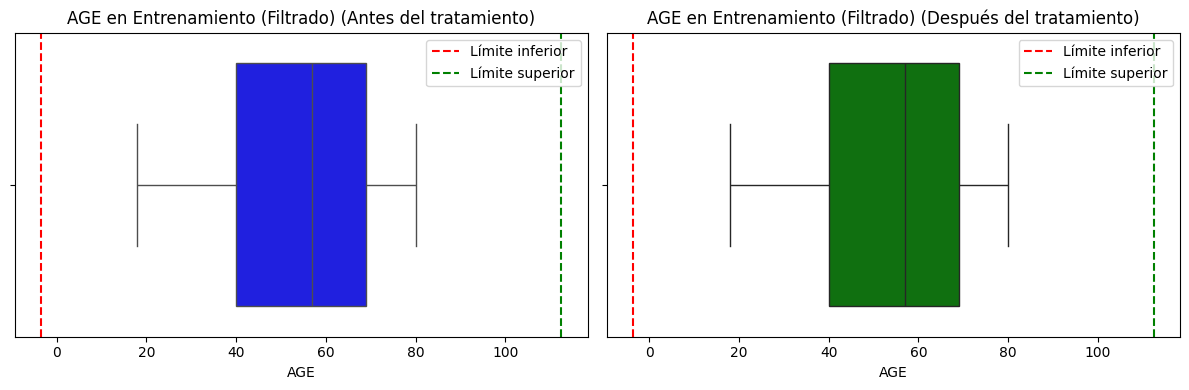

Tratando outliers en: AGE en Entrenamiento (Filtrado)
Límite inferior: -3.5, Límite superior: 112.5


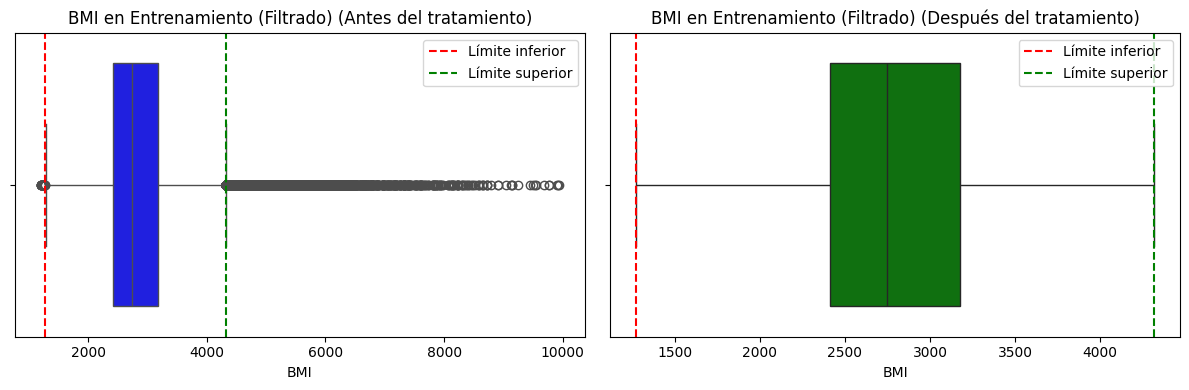

Tratando outliers en: BMI en Entrenamiento (Filtrado)
Límite inferior: 1272.5, Límite superior: 4316.5


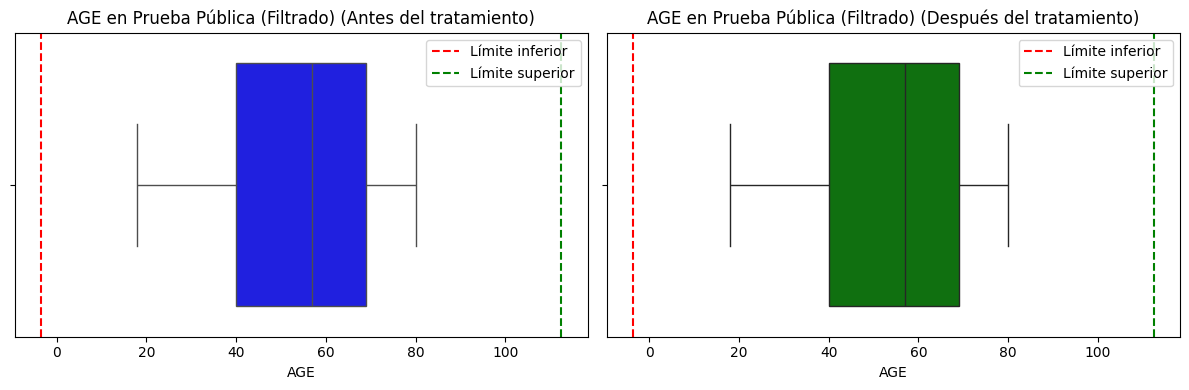

Tratando outliers en: AGE en Prueba Pública (Filtrado)
Límite inferior: -3.5, Límite superior: 112.5


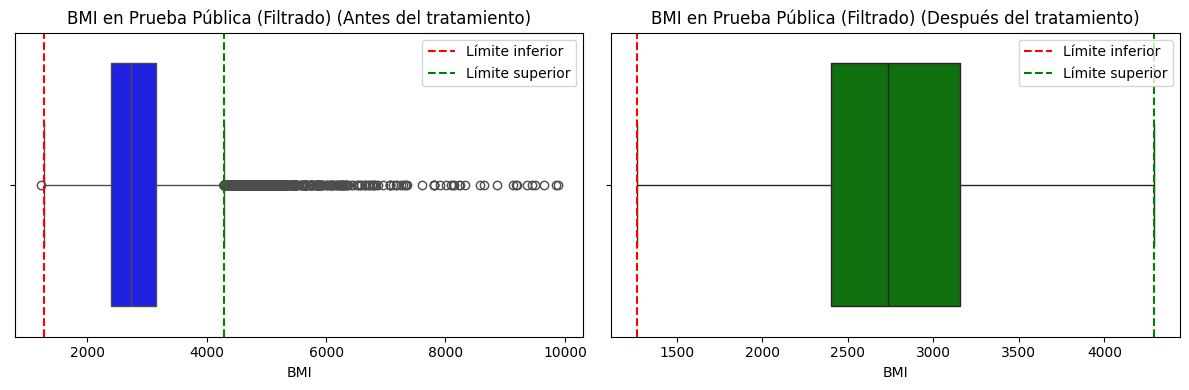

Tratando outliers en: BMI en Prueba Pública (Filtrado)
Límite inferior: 1270.5, Límite superior: 4290.5


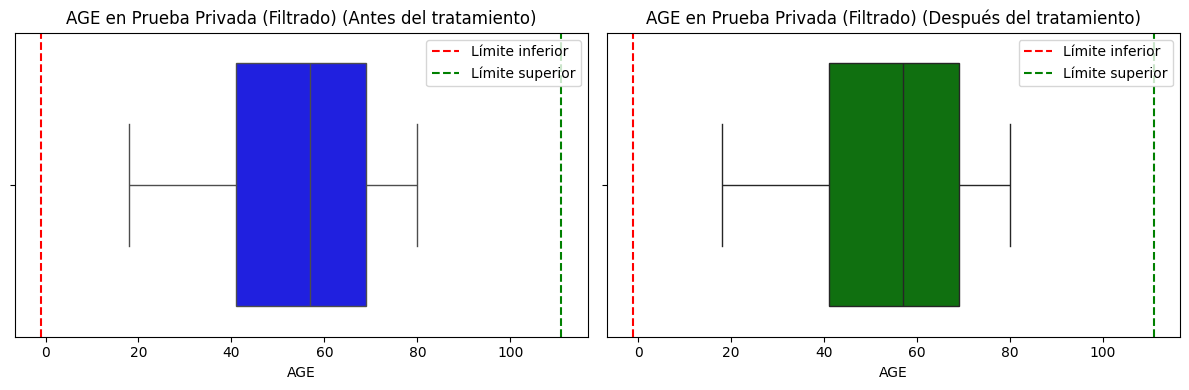

Tratando outliers en: AGE en Prueba Privada (Filtrado)
Límite inferior: -1.0, Límite superior: 111.0


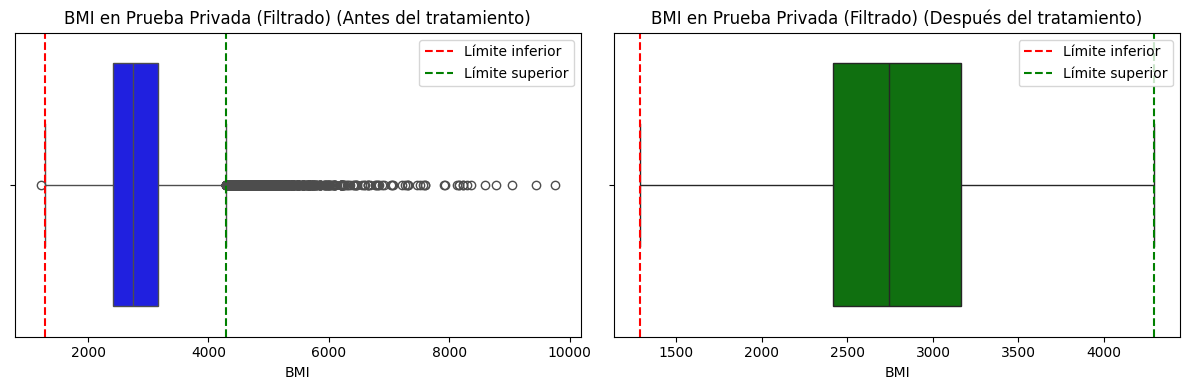

Tratando outliers en: BMI en Prueba Privada (Filtrado)
Límite inferior: 1286.0, Límite superior: 4294.0


In [57]:
# Columnas numéricas relevantes para detectar outliers
columns_to_check_outliers = ['AGE', 'BMI']

# Función para tratar outliers usando el método IQR con visualización
def treat_outliers_iqr_with_plots(df, columns, dataset_name):
    for col in columns:
        if col in df.columns:
            # Calcular límites con el método IQR
            Q1 = df[col].quantile(0.25)  # Percentil 25
            Q3 = df[col].quantile(0.75)  # Percentil 75
            IQR = Q3 - Q1
            lower_limit = Q1 - 1.5 * IQR
            upper_limit = Q3 + 1.5 * IQR

            # Visualización antes y después del tratamiento (juntos)
            plt.figure(figsize=(12, 4))

            # Antes del tratamiento
            plt.subplot(1, 2, 1)
            sns.boxplot(x=df[col], color='blue')
            plt.title(f"{col} en {dataset_name} (Antes del tratamiento)")
            plt.axvline(lower_limit, color='red', linestyle='--', label='Límite inferior')
            plt.axvline(upper_limit, color='green', linestyle='--', label='Límite superior')
            plt.legend()

            # Aplicar capping: reemplazar valores fuera de los límites
            df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
            df[col] = np.where(df[col] < lower_limit, lower_limit, df[col])

            # Después del tratamiento
            plt.subplot(1, 2, 2)
            sns.boxplot(x=df[col], color='green')
            plt.title(f"{col} en {dataset_name} (Después del tratamiento)")
            plt.axvline(lower_limit, color='red', linestyle='--', label='Límite inferior')
            plt.axvline(upper_limit, color='green', linestyle='--', label='Límite superior')
            plt.legend()

            plt.tight_layout()
            plt.show()

            print(f"Tratando outliers en: {col} en {dataset_name}")
            print(f"Límite inferior: {lower_limit}, Límite superior: {upper_limit}")

# Aplicar tratamiento de outliers en los tres datasets filtrados
print("========== Tratamiento de Outliers ==========")
treat_outliers_iqr_with_plots(train_df_filtered, columns_to_check_outliers, "Entrenamiento (Filtrado)")
treat_outliers_iqr_with_plots(test_public_df_filtered, columns_to_check_outliers, "Prueba Pública (Filtrado)")
treat_outliers_iqr_with_plots(test_private_df_filtered, columns_to_check_outliers, "Prueba Privada (Filtrado)")

### **2. Tratamiento de Valores Faltantes**

In [58]:
# Crear copias limpias de los DataFrames filtrados
train_df_clean = train_df_filtered.copy()
test_public_df_clean = test_public_df_filtered.copy()
test_private_df_clean = test_private_df_filtered.copy()

# Imputar valores faltantes en columnas numéricas con la mediana
columns_to_impute_median = ['AGE', 'BMI']

# Para cada dataset, imputar valores numéricos por separado
for col in columns_to_impute_median:
    if train_df_clean[col].isnull().any():
        train_df_clean[col] = train_df_clean[col].fillna(train_df_clean[col].median())
    if test_public_df_clean[col].isnull().any():
        test_public_df_clean[col] = test_public_df_clean[col].fillna(test_public_df_clean[col].median())
    if test_private_df_clean[col].isnull().any():
        test_private_df_clean[col] = test_private_df_clean[col].fillna(test_private_df_clean[col].median())

print("\nImputación realizada con la mediana en las siguientes columnas (numéricas):")
print(columns_to_impute_median)

# Imputar valores faltantes en columnas categóricas con la moda
columns_to_impute_mode = [
    'SEX', 'HEALTH', 'PHYSICAL_HEALTH', 'PHYSICAL_ACTIVITIES',
    'BLOOD_PRESSURE', 'HIGH_CHOLESTEROL', 'SKIN_CANCER',
    'CANCER', 'BRONCHITIS', 'KIDNEY_DISEASE', 'DIABETES',
    'ARTHRITIS', 'DIFFICULTY_WALKING', 'SMOKE'
]

# Para cada dataset, imputar valores categóricos por separado
for col in columns_to_impute_mode:
    if train_df_clean[col].isnull().any():
        train_df_clean[col] = train_df_clean[col].fillna(train_df_clean[col].mode()[0])
    if test_public_df_clean[col].isnull().any():
        test_public_df_clean[col] = test_public_df_clean[col].fillna(test_public_df_clean[col].mode()[0])
    if test_private_df_clean[col].isnull().any():
        test_private_df_clean[col] = test_private_df_clean[col].fillna(test_private_df_clean[col].mode()[0])

print("\nImputación realizada con la moda en las siguientes columnas (categóricas):")
print(columns_to_impute_mode)

# Crear un DataFrame con los valores faltantes de cada conjunto
missing_values_summary = pd.DataFrame({
    "Entrenamiento": train_df_clean.isnull().sum(),
    "Prueba Pública": test_public_df_clean.isnull().sum(),
    "Prueba Privada": test_private_df_clean.isnull().sum()
})

# Ordenar las columnas por el total de valores faltantes en el conjunto de entrenamiento
missing_values_summary = missing_values_summary.sort_values(by="Entrenamiento", ascending=False)

# Mostrar el resumen de valores faltantes lado a lado
print("\n========== Valores Faltantes Lado a Lado ==========")
print(missing_values_summary)


Imputación realizada con la mediana en las siguientes columnas (numéricas):
['AGE', 'BMI']

Imputación realizada con la moda en las siguientes columnas (categóricas):
['SEX', 'HEALTH', 'PHYSICAL_HEALTH', 'PHYSICAL_ACTIVITIES', 'BLOOD_PRESSURE', 'HIGH_CHOLESTEROL', 'SKIN_CANCER', 'CANCER', 'BRONCHITIS', 'KIDNEY_DISEASE', 'DIABETES', 'ARTHRITIS', 'DIFFICULTY_WALKING', 'SMOKE']

========== Valores Faltantes Lado a Lado ==========
                     Entrenamiento  Prueba Pública  Prueba Privada
AGE                            0.0               0             0.0
HEALTH                         0.0               0             0.0
SKIN_CANCER                    0.0               0             0.0
SEX                            0.0               0             0.0
PHYSICAL_HEALTH                0.0               0             0.0
PHYSICAL_ACTIVITIES            0.0               0             0.0
KIDNEY_DISEASE                 0.0               0             0.0
HIGH_CHOLESTEROL               0

### **3. Análisis exploratorio adicional**

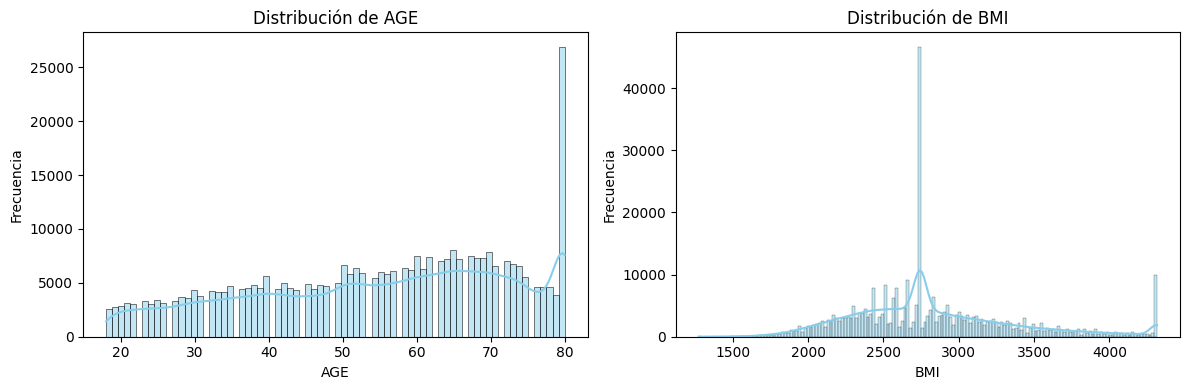

In [59]:
# Visualización de distribuciones lado a lado
numerical_columns = ['AGE', 'BMI']  # Ajusta según tus columnas numéricas

plt.figure(figsize=(12, 4))  # Ajustar tamaño
for i, col in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i + 1)  # Subplot en una fila
    sns.histplot(train_df_clean[col], kde=True, color='skyblue')
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

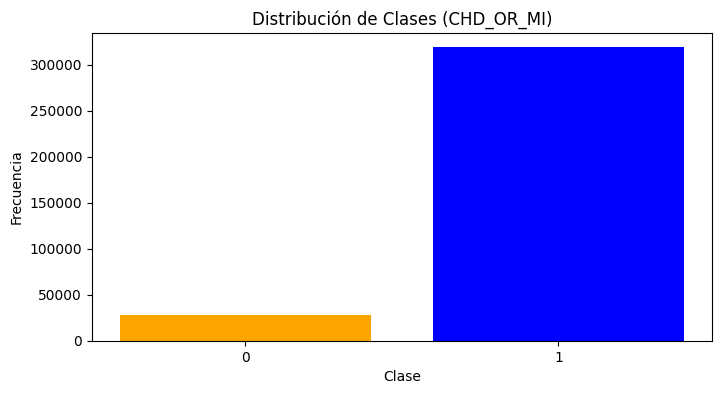

In [60]:
# Balance de clases en una sola línea
class_balance = train_df_clean['CHD_OR_MI'].value_counts()

plt.figure(figsize=(8, 4))
plt.bar(class_balance.index, class_balance.values, color=['blue', 'orange'])
plt.title("Distribución de Clases (CHD_OR_MI)")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.xticks(class_balance.index, labels=["1", "0"])
plt.show()

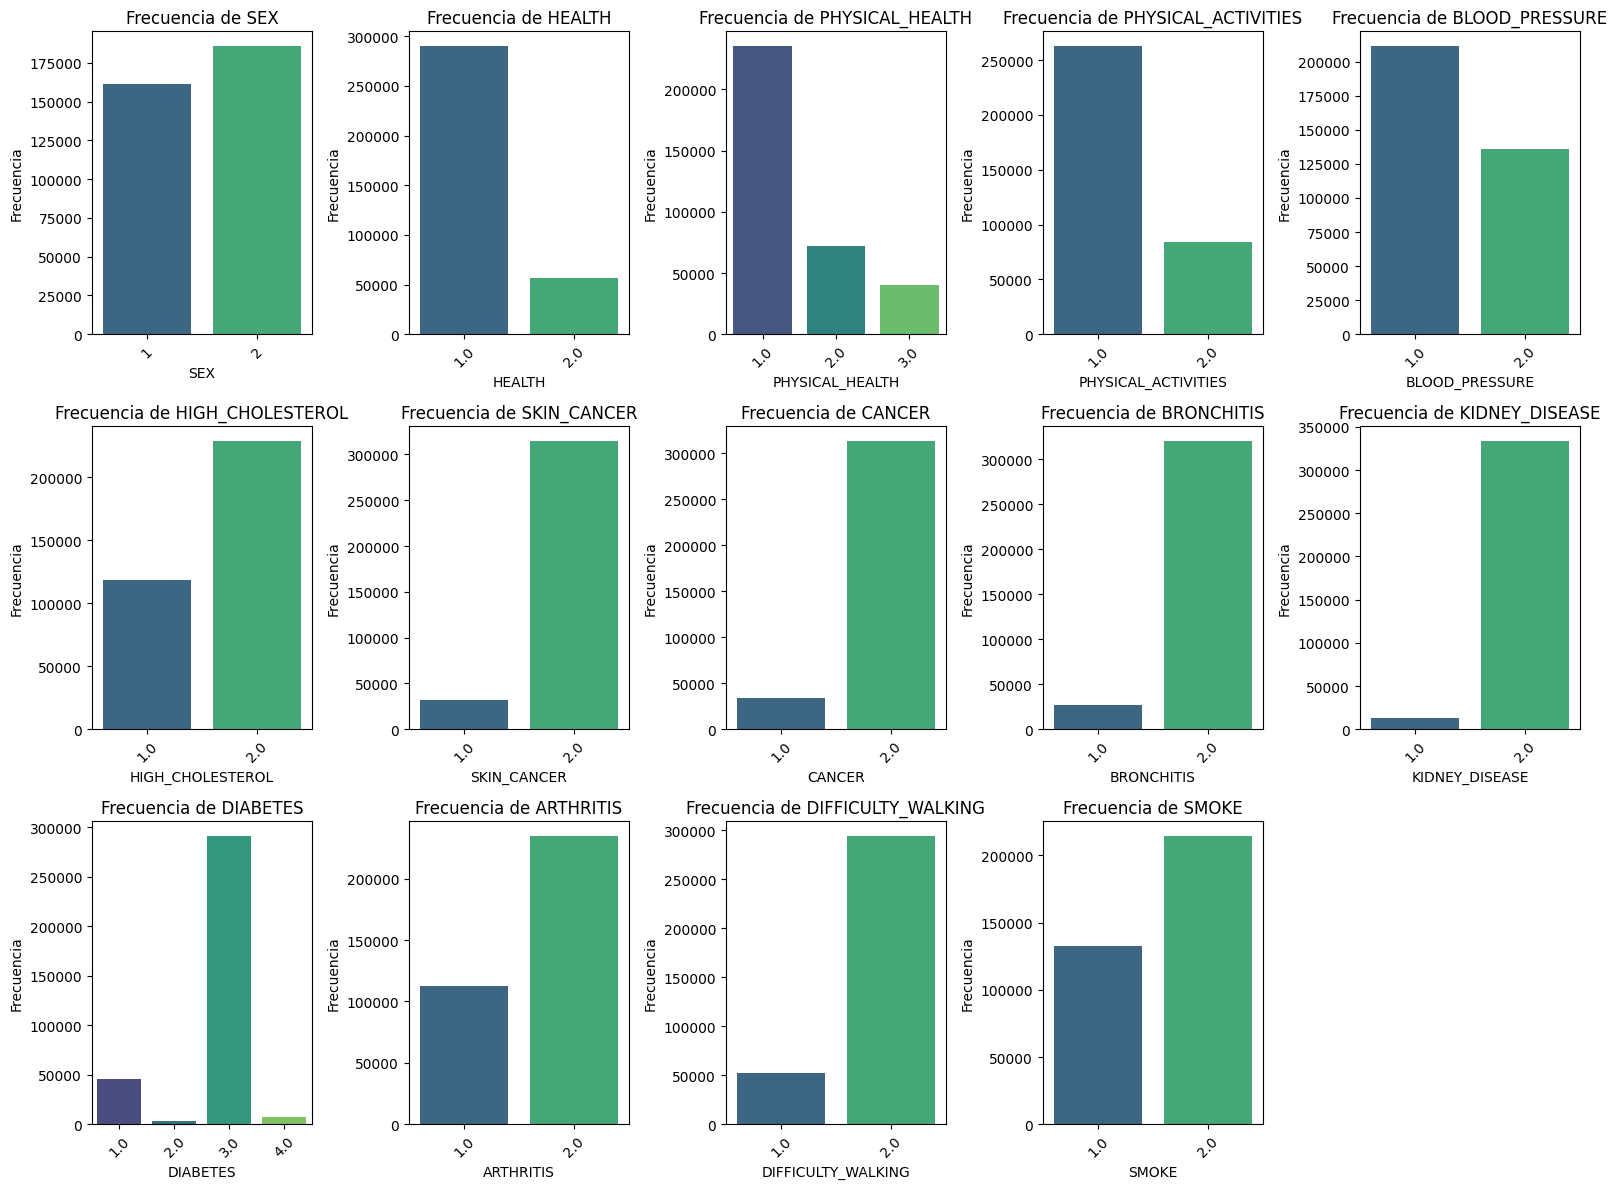

In [61]:
# Visualización de frecuencias para columnas categóricas
categorical_columns = [
    'SEX', 'HEALTH', 'PHYSICAL_HEALTH', 'PHYSICAL_ACTIVITIES',
    'BLOOD_PRESSURE', 'HIGH_CHOLESTEROL', 'SKIN_CANCER',
    'CANCER', 'BRONCHITIS', 'KIDNEY_DISEASE', 'DIABETES',
    'ARTHRITIS', 'DIFFICULTY_WALKING', 'SMOKE'
]  # Ajusta según tus columnas categóricas

# Configurar el número de filas y columnas
num_cols = 5  # Número de columnas
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Calcular filas dinámicamente

plt.figure(figsize=(16, 12))  # Ajustar el tamaño del gráfico
for i, col in enumerate(categorical_columns):
    plt.subplot(num_rows, num_cols, i + 1)  # Subplots distribuidos en 3 filas y 5 columnas
    sns.countplot(data=train_df_clean, x=col, palette='viridis')
    plt.title(f"Frecuencia de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)

plt.tight_layout()  # Ajustar diseño para evitar solapamientos
plt.show()

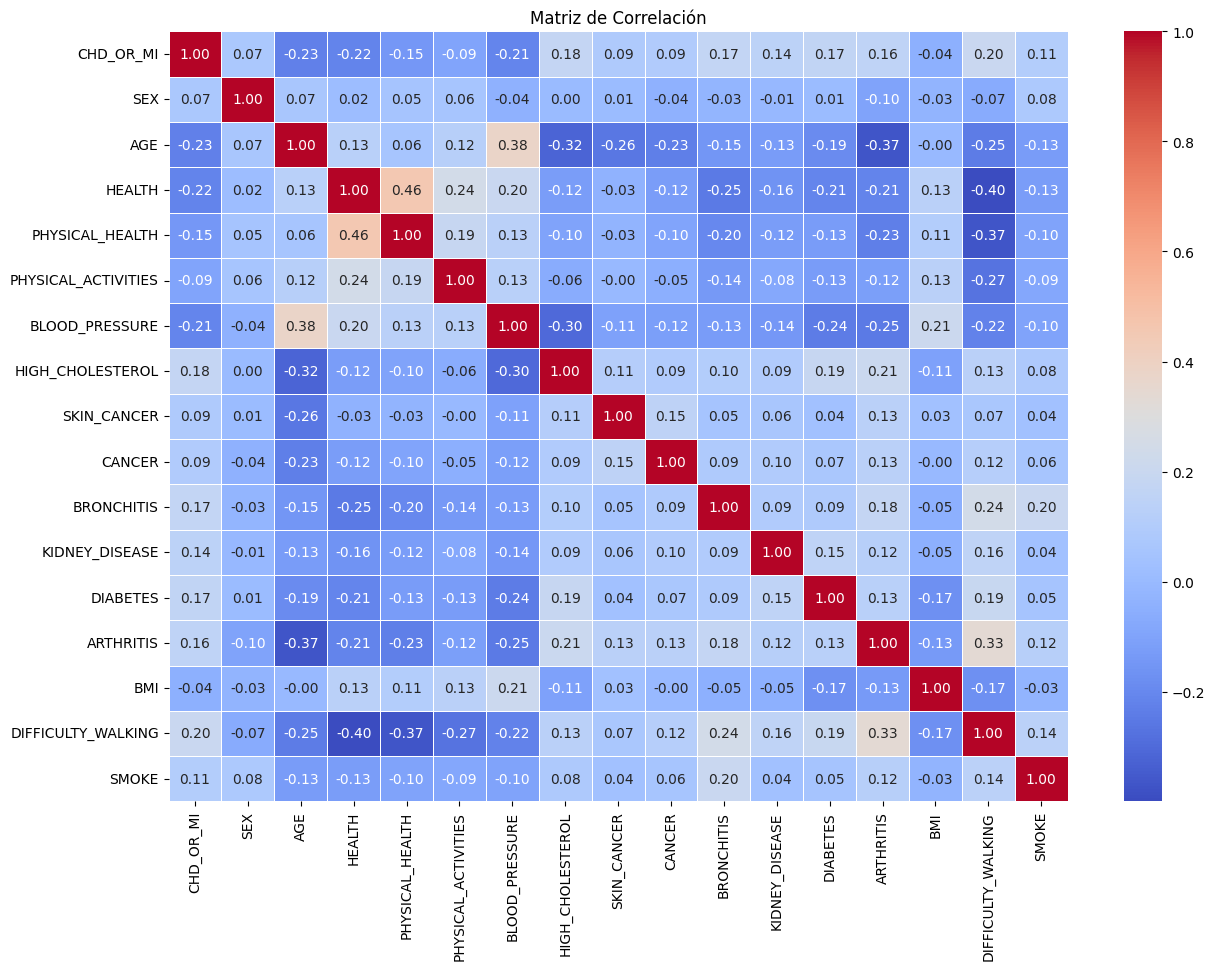

In [62]:
# Matriz de correlación
plt.figure(figsize=(14.5, 10))
correlation_matrix = train_df_clean.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

## **Balanceo de Clases**

In [63]:
# Separar características (X) y variable objetivo (y)
X = train_df_clean.drop(columns=['CHD_OR_MI'])
y = train_df_clean['CHD_OR_MI']

# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balancear las clases usando SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Confirmar las dimensiones tras el balanceo
print("========== Dimensiones de los Conjuntos ==========")
print(f"Conjunto de Entrenamiento (Balanceado): {X_train_balanced.shape}, {y_train_balanced.shape}")
print(f"Conjunto de Validación: {X_val.shape}, {y_val.shape}")

========== Dimensiones de los Conjuntos ==========
Conjunto de Entrenamiento (Balanceado): (510380, 16), (510380,)
Conjunto de Validación: (69450, 16), (69450,)


### **Análisis de Importancia de Características**

In [64]:
# Usar Random Forest para determinar importancia de características
rf_temp = RandomForestClassifier(random_state=42)
rf_temp.fit(X_train_balanced, y_train_balanced)

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_temp.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Mantener solo las características importantes
important_features = feature_importances[feature_importances['Importance'] > 0.01]['Feature'].tolist()
X_train_balanced = X_train_balanced[important_features]
X_val = X_val[important_features]
test_public_df_clean = test_public_df_clean[important_features + ['ID']]
test_private_df_clean = test_private_df_clean[important_features + ['ID']]

## **Entrenamiento del modelo**

### **Entrenamiento con 4 Modelos para realizar comparaciónes y optimizaciones: Random Forest, Gradient Boosting, XGBoost y LightGBM**

In [67]:
# Definir modelos
models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42, class_weight='balanced')
}

# Entrenar y evaluar modelos
results = {}
for name, model in models.items():
    print(f"Entrenando {name}...")
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    results[name] = {
        'model': model,
        'f1_score': f1,
        'classification_report': report,
        'confusion_matrix': cm
    }
    print(f"{name} F1-Score: {f1:.4f}\n{report}\nConfusion Matrix:\n{cm}\n")

# Seleccionar el mejor modelo
best_model_name = max(results, key=lambda x: results[x]['f1_score'])
best_model = results[best_model_name]['model']
print(f"\nEl modelo con el mejor F1-Score es: {best_model_name} con F1-Score: {results[best_model_name]['f1_score']:.4f}\n")

# Nota explicativa
print("Nota 1: El conjunto de datos de entrenamiento ha sido balanceado utilizando SMOTE para mejorar la representación de la clase minoritaria durante el aprendizaje.")
print("Nota 2: El conjunto de validación no ha sido balanceado para reflejar mejor la distribución real de las clases en un entorno práctico.")
print("Nota 3: Aunque se intentó evaluar con un conjunto de validación balanceado, el rendimiento del F1-Score disminuyó significativamente, lo que indicaba una menor capacidad de generalización del modelo.")

Entrenando Random Forest...
Random Forest F1-Score: 0.9490
              precision    recall  f1-score   support

         0.0       0.31      0.14      0.19      5652
         1.0       0.93      0.97      0.95     63798

    accuracy                           0.90     69450
   macro avg       0.62      0.56      0.57     69450
weighted avg       0.88      0.90      0.89     69450

Confusion Matrix:
[[  806  4846]
 [ 1818 61980]]

Entrenando Gradient Boosting...
Gradient Boosting F1-Score: 0.9550
              precision    recall  f1-score   support

         0.0       0.44      0.17      0.25      5652
         1.0       0.93      0.98      0.96     63798

    accuracy                           0.92     69450
   macro avg       0.69      0.58      0.60     69450
weighted avg       0.89      0.92      0.90     69450

Confusion Matrix:
[[  985  4667]
 [ 1229 62569]]

Entrenando XGBoost...
XGBoost F1-Score: 0.9572
              precision    recall  f1-score   support

         0.0      

### **Ajuste de Umbral de Decisión**

In [68]:
y_probs = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Calcular F1-Score para cada umbral
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Mejor umbral para {best_model_name}: {optimal_threshold}")

Mejor umbral para LightGBM: 0.38911794272640104


## **Generación y descarga de predicciones**

In [69]:
def generate_predictions(model, test_df, threshold):
    test_features = test_df.drop(columns=['ID'], errors='ignore')
    test_probs = model.predict_proba(test_features)[:, 1]
    test_preds = (test_probs >= threshold).astype(int)
    return pd.DataFrame({
        'ID': test_df['ID'],
        'CHD_OR_MI': test_preds
    })

# Generar predicciones para los conjuntos de prueba
predictions_public = generate_predictions(best_model, test_public_df_clean, optimal_threshold)
predictions_private = generate_predictions(best_model, test_private_df_clean, optimal_threshold)

# Combinar y guardar las predicciones
final_predictions = pd.concat([predictions_public, predictions_private], axis=0)
final_predictions.to_csv('resultados.csv', index=False)

print("Archivo 'resultados.csv' generado correctamente con las predicciones combinadas.\n")

# Mostrar resumen de resultados
print("Resultados de los modelos:")
for name, result in results.items():
    print(f"{name}: F1-Score = {result['f1_score']:.4f}")

Archivo 'resultados.csv' generado correctamente con las predicciones combinadas.

Resultados de los modelos:
Random Forest: F1-Score = 0.9490
Gradient Boosting: F1-Score = 0.9550
XGBoost: F1-Score = 0.9572
LightGBM: F1-Score = 0.9575
